In [10]:
import random
import copy
from collections import namedtuple
from dataclasses import dataclass
import datetime
import typing
import functools
from pprint import pprint

import jax
import jax.numpy as jnp
from jax import grad, value_and_grad, jit, vmap
from jax.experimental import optimizers
from jax.experimental import stax
import optax
import haiku as hk
from jax.tree_util import tree_flatten

import pyspiel
import open_spiel
import dm_env
import acme
from acme.agents import agent
from acme.agents import replay
# from acme import core
# from acme import specs
# from acme import types
# from acme import wrappers
from acme.jax.utils import prefetch
from acme.environment_loops.open_spiel_environment_loop import OpenSpielEnvironmentLoop
from acme.wrappers.open_spiel_wrapper import OpenSpielWrapper

from tqdm.notebook import tqdm
import numpy as np
import trueskill

In [11]:
import moozi as mz
from moozi import Game, Action, ActionHistory, Player
from moozi.model import Model

In [12]:
class RandomActor(acme.core.Actor):
    def __init__(self, adder):
        self._adder = adder
        
    def select_action(self, observation: acme.wrappers.open_spiel_wrapper.OLT) -> int:
        legals = np.array(np.nonzero(observation.legal_actions), dtype=np.int32)
        return np.random.choice(legals[0])

    def observe_first(self, timestep: dm_env.TimeStep):
        self._adder.add_first(timestep)

    def observe(self, action: acme.types.NestedArray, next_timestep: dm_env.TimeStep):
        self._adder.add(action, next_timestep)

    def update(self, wait: bool = False):
        pass

In [13]:
class MyNetwork(typing.NamedTuple):
    init: typing.Callable = None
    apply_initial_inference: typing.Callable = None
    apply_recurrent_inference: typing.Callable = None

In [14]:
def get_network(dim_image, dim_actions, dim_repr):
    initial_inference = hk.without_apply_rng(hk.transform(
        lambda x: Model(dim_actions, dim_repr).initial_inference(x)))
    recurrent_inference = hk.without_apply_rng(hk.transform(
        lambda x, y: Model(dim_actions, dim_repr).recurrent_inference(x, y)))
    def init(random_key):
        key_1, key_2 = jax.random.split(random_key)
        params = hk.data_structures.merge(
            initial_inference.init(key_1, jnp.ones(dim_image)),
            recurrent_inference.init(key_2, jnp.ones(dim_repr), jnp.ones(dim_actions))
        )
        return params
    return MyNetwork(
        init,
        initial_inference,
        recurrent_inference
    )

In [15]:
def loss_fn(network, params, batch):
    inf_out = network.apply_initial_inference(
        params, batch.data.observation.observation)
    return jnp.mean(jnp.square(inf_out.value - batch.data.reward))

In [20]:
# https://github.com/deepmind/acme/blob/a6b4162701542ed08b0b911ffac7c69fcb1bb3c7/acme/agents/jax/dqn/learning_lib.py#L68
class TrainingState(typing.NamedTuple):
    params: typing.Any
    opt_state: optax.OptState
    steps: int
    rng_key: jax.random.PRNGKey
        
class MyLearner(acme.Learner):
    def __init__(
        self,
        network,
        loss_fn,
        optimizer,
        data_iterator, 
        random_key
    ):
        self.network = network
        self._loss = jax.jit(functools.partial(loss_fn, self.network))
        
        @jax.jit
        def sgd_step(training_state, batch):
            key, new_key = jax.random.split(training_state.rng_key)
            loss, grads = jax.value_and_grad(loss_fn)(training_state.params, batch)
            updates, new_opt_state = optimizer.update(grads, training_state.opt_state)
            new_params = optax.apply_updates(training_state.params, updates)
            steps = training_state.steps + 1
            new_training_state = TrainingState(new_params, new_opt_state, steps, new_key)
            return new_training_state, loss
        
        self._sgd_step = sgd_step
        self._data_iterator = prefetch(data_iterator)
        self._logger = acme.utils.loggers.TerminalLogger(time_delta=1., print_fn=print)
        
        key_params, key_state = jax.random.split(random_key, 2)
        params = self.network.init(key_params)
        self._state = TrainingState(
            params=params,
            opt_state=optimizer.init(params),
            steps=0,
            rng_key=key_state
        )
        
    def step(self):
        batch = next(self._data_iterator)
        self._state, loss = self._sgd_step(self._state, batch)
        self._logger.write(loss)
        
    def get_variables(self, names):
        return [self._state.params]
    
    def save(self):
        return self._state
    
    def restore(self, state):
        self._state = state

In [21]:
class MyAgentConfig(typing.NamedTuple):
    batch_size: int = 32
    learning_rate: float = 1e-3
    min_observation: int = 10
    observations_per_step: float = 0.1

class MyAgent(agent.Agent):
    def __init__(self, env_spec, config, network):
        reverb_replay = replay.make_reverb_prioritized_nstep_replay(
            env_spec, batch_size=config.batch_size
        )
        optimizer = optax.adam(config.learning_rate)
        actor = RandomActor(reverb_replay.adder)
        learner = MyLearner(
            network=network,
            loss_fn=loss_fn,
            optimizer=optimizer,
            data_iterator=reverb_replay.data_iterator, 
            random_key=jax.random.PRNGKey(0)
        )
        super().__init__(
            actor=actor,
            learner=learner,
            min_observations=config.min_observation,
            observations_per_step=config.observations_per_step
        )

In [22]:
raw_env = open_spiel.python.rl_environment.Environment('catch(columns=3,rows=4)')
env = acme.wrappers.open_spiel_wrapper.OpenSpielWrapper(raw_env)
env = acme.wrappers.SinglePrecisionWrapper(env)
env_spec = acme.make_environment_spec(env)

In [23]:
dim_actions = env_spec.actions.num_values
dim_image = env_spec.observations.observation.shape
dim_repr = 3

In [25]:
network = get_network(dim_image, dim_actions, dim_repr)
my_agent = MyAgent(env_spec, MyAgentConfig(), network)
loop = OpenSpielEnvironmentLoop(environment=env, actors=[my_agent])

In [ ]:
loop.run(num_episodes=100)

In [ ]:
loop

In [113]:
# actor = RandomActor(reverb_replay.adder)
# loop = OpenSpielEnvironmentLoop(environment=env, actors=[actor], logger=logger)

In [120]:
data_iter = prefetch(reverb_replay.data_iterator)
opt_state = optimizer.init(params)
training_state = TrainingState(params, opt_state, 0, jax.random.PRNGKey(1))
losses = []
for _ in range(10000):
    batch = next(data_iter)
    training_state, loss = sgd_step(training_state, batch)
    losses.append(loss)

In [121]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [126]:
import matplotlib.pyplot as plt

x = np.linspace(0, len(losses), num=len(losses))
y = smooth(losses, 500)

In [85]:
len(losses)

10000

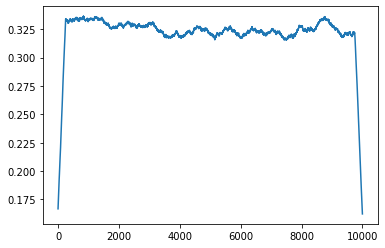

In [127]:
%matplotlib inline
plt.plot(x, y)
plt.show()